In [1]:
# Import required modules
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset from a CSV file (replace 'your_dataset.csv' with your actual file name)
data = pd.read_csv('TrainingDataStand.csv')


In [3]:

# Separate input features and output feature
X = data.iloc[:, :4].values  
y = data.iloc[:, 4].values  


In [4]:
X_seq = []  # each input will be 16-dimensional: 4 features × 4 timesteps
y_seq = []

spacing = 20  # spacing between each time point (200ms)
sequence_length = 4
required_history = spacing * (sequence_length - 1)

for i in range(required_history, len(X)):
    # Select timesteps: [t - 60, t - 40, t - 20, t]
    indices = [i - spacing * j for j in reversed(range(sequence_length))]
    window = np.concatenate([X[j] for j in indices], axis=0)  # Flattened to 16-dim
    X_seq.append(window)
    y_seq.append(y[i])  # target at current time step

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)


In [6]:
print(X_seq.shape)

(178831, 16)


In [7]:

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [8]:

# Define the FNN model
model = Sequential([
    # Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    # Dense(8, activation='relu'),
    # Dense(1, activation='tanh')  # Output in range [-1, 1]
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='tanh')  # Output in range [-1, 1]
])

C:\Users\Saian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Specify callback for logging in-epoch loss
from tensorflow.keras.callbacks import Callback
class BatchLossLogger(Callback):
    def on_train_begin(self, logs=None):
        self.batch_losses = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs.get('loss'))

# Instantiate the callback
batch_loss_logger = BatchLossLogger()

In [10]:
# Start the timer
start_time = time.time()

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=1024,
    verbose=1,
    callbacks=[batch_loss_logger]
)

# Stop the timer
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training Time: {elapsed_time:.2f} seconds")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,713 (14.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0221 - mae: 0.0743 - val_loss: 0.0010 - val_mae: 0.0211
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6660e-04 - mae: 0.0196 - val_loss: 6.4142e-04 - val_mae: 0.0170
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9725e-04 - mae: 0.0165 - val_loss: 4.9387e-04 - val_mae: 0.0150
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7581e-04 - mae: 0.0148 - val_loss: 4.1479e-04 - val_mae: 0.0139
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.0025e-04 - mae: 0.0137 - val_loss: 3.7291e-04 - val_mae: 0.0133
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5361e-04 - mae: 0.0129 - val_loss: 3.3779e-04 - val_mae: 0.0127
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2285e-04 - mae: 0.0124 - val_loss: 3.1228e-04 - val_mae: 0.0122
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0219e-04 - mae: 0.0120 - val_loss: 2.9329e-04 - val_mae: 0.0118


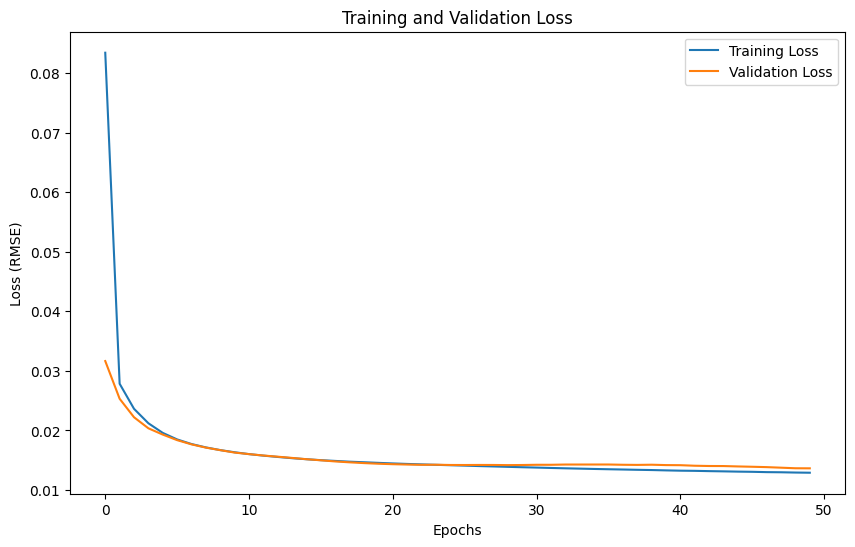

In [15]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(np.sqrt(history.history['loss']), label='Training Loss')
plt.plot(np.sqrt(history.history['val_loss']), label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (RMSE)')
# plt.ylim([0.001, 0.005])
plt.legend()
plt.show()


839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


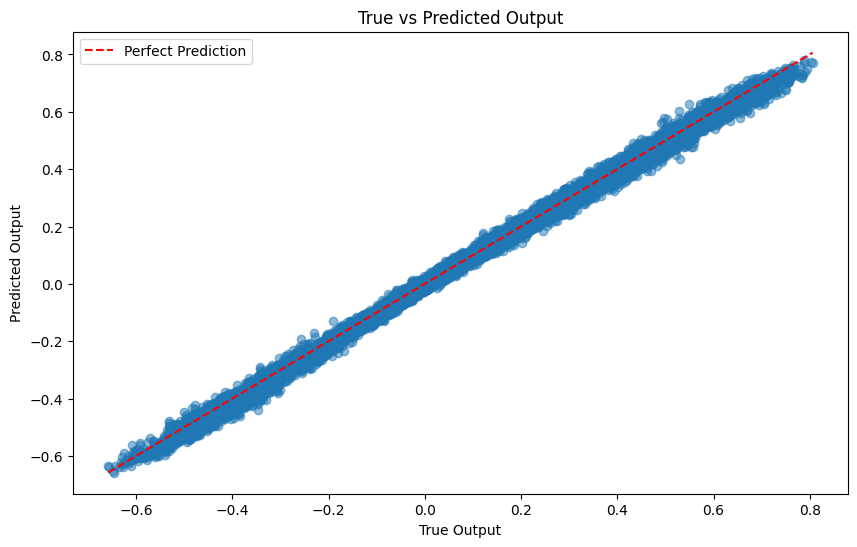

In [16]:
# Predict on test set and visualize results
y_pred = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('True vs Predicted Output')
plt.xlabel('True Output')
plt.ylabel('Predicted Output')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.show()

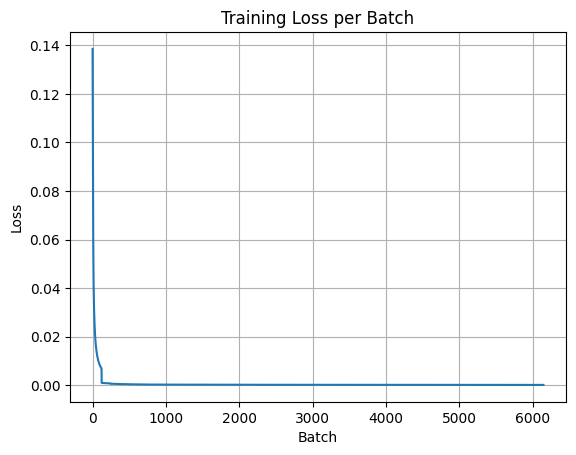

In [17]:
# Plot batch loss
plt.plot(batch_loss_logger.batch_losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss per Batch')
plt.grid(True)
# plt.ylim([0.001, 0.002])
plt.show()

In [13]:
# Export the model
model.export("SteeringModel_Iteration80")

INFO:tensorflow:Assets written to: SteeringModel_Iteration80\assets


INFO:tensorflow:Assets written to: SteeringModel_Iteration80\assets


Saved artifact at 'SteeringModel_Iteration80'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 16), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2379785587216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379785588368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379785586640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379785587024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379785588944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379785586256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379785589328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2379785588176: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [14]:
# Feature importance
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, scoring='neg_mean_absolute_error')
feature_importance = result.importances_mean
print("Feature Importance:", feature_importance)

839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 880us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 910us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 880us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 859us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 927us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 916us/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step
839/839 ━━━